# Sentiment Analysis and Topic Modelling for YouTube Comments

In this notebook, we are going to explore one of the richest, yet extremely messy, databases available online, YouTube comments! To be fair, working with any text data is always often messy since we have to deal with a lot of potential errors when analyzing the data such as typos, abbreviations, etc. However, there are a lot of tools and pre-trained models available online that are ready to use to help us clean, manipulate, and ultimately infer insights from YouTube comments. We are particularly interested in two type of inferences in this notebook, sentiment score of the video and topic modelling generated from the comments. 

Sentiment analysis is a process of identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral. This is really helpful for content creators as this tool can serve as additional data points to their video likes/dislikes and help them determine which video should be build upon and which should be stopped. Topic modelling is another text analysis tool that content creators can utilize to find which ideas they can use for their next video. With that said, let's start by extracting YouTube comments for our analysis.

Normaly, developers request a key access to Google in order to be able to extract comments from YouTube. However, there several other "unofficial" methods we can use to do this. One of them is by using a Python module named "youtube_comment_downloader." If you're interested in understanding this module in more detail, feel free to their repo [here](https://github.com/egbertbouman/youtube-comment-downloader).

In [1]:
## run this code to install the library
# !pip install youtube_comment_downloader

In [2]:
"""This cell contains the YouTube scraper to extract the required data. 
However, we already have the data downloaded beforehand, so we can skip this cell.
Feel free to try it out though! It is very easy to use and fast.
"""

# from itertools import islice
# from youtube_comment_downloader import *

# # create an instance of YoutubeCommentDownloader
# downloader = YoutubeCommentDownloader()

# # get the comments from the url
# comments = downloader.get_comments_from_url('paste your url here')

# # create an empty list to store the comments
# all_comments = []
# # iterate over the comments and store them in the list
# # change the number in islice to the number of comments you want to extract
# for comment in islice(comments, 1000):
#     print(comment)
#     all_comments.append(comment)

'This cell contains the YouTube scraper to extract the required data. \nHowever, we already have the data downloaded beforehand, so we can skip this cell.\nFeel free to try it out though! It is very easy to use and fast.\n'

Now that's done, we have our data in its raw format and ready to be used. More context regarding our use case, the comments are taken from videos discussing the top n best movies of all time, of the past century, and in one particular genre: sci-fi. The motivation behind this exercise is that the author has always found it hard to find a reliable recommendation list of movies. So, why not make our own movie recommendation engine using what people say and recommend in the comment section? Moreover, ranking videos often spark a controversial debate, as these rankings are mostly generated from a subjective perspective. It might be interesting whether people agree with the ranks of each video or not.

Let's first set up our environment and upload our data. The comments are scrapped from four videos. All URLs are available below.

In [ ]:
!pip install transformers
!pip install torch

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re
import pandas as pd

Note: If you need the exact data used on this analysis, feel free to reach out at mangara@sas.upenn.edu.

In [4]:
# # load the dataset

# url: https://www.youtube.com/watch?v=S-B30QlAvDQ
df_comment1 = pd.read_csv('the_30_greatest_films2.csv')

# url: 'https://www.youtube.com/watch?v=arTcRGsms6g'
df_comment2 = pd.read_csv('top_20movies_of_the_century2.csv')

# url: 'https://www.youtube.com/watch?v=aH3qsEvB3ZE&t=732s'
df_comment3 = pd.read_csv('top_20_underated_movies.csv')

# url: 'https://www.youtube.com/watch?v=E_lVUq73Cxs'
df_comment4 = pd.read_csv('top_20_scifi_movies.csv')

df_comment1['title'] = 'the_30_greatest_films'
df_comment2['title'] = 'top_20movies_of_the_century'
df_comment3['title'] = 'top_20_underated_movies'
df_comment4['title'] = 'top_20_scifi_movies'

print(len(df_comment1))
print(len(df_comment2))
print(len(df_comment3))
print(len(df_comment4))

569
1000
841
1000


In [5]:
# # combine the dataframes, drop unnecessary columns, and reset the index

df_comment_combined = pd.concat([df_comment1, df_comment2, df_comment3, df_comment4], axis=0)
df_comment_combined.rename(columns={'text':'Comment'}, inplace=True)
df_comment_combined.drop(columns=['cid','author','channel','photo','heart'], inplace=True)
df_comment_combined.reset_index(drop=True, inplace=True)

When working with text data, we often need to pre-process it first so we can weed out unnecessary words and group the same words together regardless of its variance. For example, we can group the word "I am", "I'm" and "Im" together. However, for the first part of this analysis, we are interested in using a deep learning model via the transformers module. Transformers does not require us to pre-process our text first since it take all words into the model and process it automatically. In other words, transformers module pre-process our data for us. With that said, we might want to remove non-ASCII characters, such as emojis, first to avoid any errors in our analysis.

In [6]:
# remove emoji and non-ascii characters
df_comment_combined['Comment'] = df_comment_combined['Comment'].apply(lambda x: re.sub(r'[^\x00-\x7F]+',' ', x))

# remove \n and \r characters with space
df_comment_combined['Comment'] = df_comment_combined['Comment'].apply(lambda x: re.sub(r'[\n\r]+',' ', x))
df_comment_combined['Comment'] = df_comment_combined['Comment'].apply(lambda x: re.sub(r'[\n]+',' ', x))
df_comment_combined['Comment'] = df_comment_combined['Comment'].apply(lambda x: re.sub(r'[\r]+',' ', x))

# convert to string
df_comment_combined['Comment'] = df_comment_combined['Comment'].astype(str)
len(df_comment_combined)

3410

Let's do a bit of EDA before predicting each comment's sentiment class.

In [7]:
# print top 10 comment with the most votes 
pd.set_option('display.max_colwidth', 300)
df_comment_combined.sort_values(by='votes', ascending=False).head(10)

,Comment,time,votes,reply,time_parsed,title
400,"30. Oldboy - 2:48 29. Sunrise: A Song of Two Humans - 7:00 28. Citizen Kane - 11:21 27. My Dinner with Andre - 15:32 26. Akira - 19:17 25. Gone with the Wind - 23:57 24. The Cook, the Thief, His Wife & Her Lover - 27:45 23. Mirror - 32:23 22. Ordet - 35:43 21. La Haine - 39:31 20. Love Exposure ...",12 days ago,420,False,1.669908e+09,the_30_greatest_films
569,Which movie from the last 20 years is your fav?,2 years ago,311,False,1.607874e+09,top_20movies_of_the_century
2216,20. The Life Aquatic with Steve Zissou (2004) 19. Dredd (2012) 18. Dan in Real Life (2007) 17. Thief (1981) 16. Kiss Kiss Bang Bang (2005) 15. Gattaca (1997) 14. Matchstick Men (2003) 13. 50/50 (2011) 12. Detroit (2017) 11. Everybody Wants Some!! (2016) 10. The Place Beyond the Pines (2012) 9. J...,2 weeks ago,257,False,1.669739e+09,top_20_underated_movies
3143,The Thing deserves an honorable mention because it blends innovative practical effects and horror with themes of mistrust and paranoia.,2 months ago,197,False,1.665674e+09,top_20_scifi_movies
320,"Citizen Kane only changed the perception of cinema as high art in Hollywood/USA. In Europe, the avant-garde filmmakers from German Expressionism, French Impressionism, Soviet montage theory, Surrealism, Poetic Realism and the very beginnings/antecedents of Italian Neorealism had already changed ...",12 days ago (edited),184,False,1.669908e+09,the_30_greatest_films
232,In case anyone's wondering about the films in the intro: 0:00 8 1/2 0:10 There Will Be Blood 0:15 Salo 0:22 Duck Soup 0:29 Singin' in the Rain 0:34 Rashomon 0:40 Do the Right Thing 0:47 Chimes at Midnight 1:00 Ivan the Terrible,11 days ago,138,False,1.669995e+09,the_30_greatest_films
2218,"Prisoners really threw me for a curveball, and it s ending was the most surprising. It was interesting to see Jackman in something other than the X-Men (at the time).",2 weeks ago,117,False,1.669739e+09,top_20_underated_movies
2936,"I would've included Arrival (Denis Villeneuve), Interstellar (Christopher Nolan) and A Clockwork Orange (Stanley Kubrick)",2 months ago,101,False,1.665674e+09,top_20_scifi_movies
1127,Other movies that I personally would include before many of these on this list: The Pianist Whiplash Prisoners Children of Men The Departed Inglourious Basterds Slumdog Millionaire Birdman The Prestige The Lives of Others,2 years ago,78,False,1.607874e+09,top_20movies_of_the_century
351,"One of my earliest memories is of being in a movie theater, terrified by the spectacle of E.T. being chased through the woods, and confused at my parents' assurances that it was OK because none of it was real. What a weird world we live in, exposed to magical stories that can inform and enrich ...",12 days ago (edited),71,False,1.669908e+09,the_30_greatest_films


It seems that the top 10 most-liked comments contain other movies that are not listed in the videos. This is extremely insightful as the votes give additional data points that we can use to build our recommendation engine to decide whether a movie is worth a watch or not. We can assume that the movies listed in comments with high votes/likes are worth watching since other people validate these movies via likes.

In [8]:
# create a new column for votes group: 0-10, 10-20, 20-50, 50-100, above 100
df_comment_combined['votes_group'] = pd.cut(df_comment_combined['votes'], bins=[0, 10, 20, 50, 100, 100000], labels=['0-10', '10-20', '20-50', '50-100', 'above 100'])

# show the number of comments in each group
print(df_comment_combined['votes_group'].value_counts())

# count comments that has 0 votes
df_comment_combined[df_comment_combined['votes']==0].count()

0-10         1156
10-20          41
20-50          33
50-100          9
above 100       8
Name: votes_group, dtype: int64


Comment        2163
time           2163
votes          2163
reply          2163
time_parsed    2163
title          2163
votes_group       0
dtype: int64

As we can see, the majority of the comments only have 0-10 likes. Therefore, we can assume that other comments that have a vote of 10 and above must have a pretty valid point or good list of movies. We can use this insight as a feature when we want to build our recommendation engine going forward.

Now let's create our tokenizer and transformers model using a pre-trained model available on Hugging Face. After that is done, we can create a function to generate the sentiment class for each of our comments. 

We are using a multilingual model from nlptown. This a bert-base-multilingual-uncased model fine-tuned for sentiment analysis on product reviews in six languages: English, Dutch, German, French, Spanish and Italian. It predicts the sentiment of the review as a number of stars (between 1 and 5).

This model is intended for direct use as a sentiment analysis model for product reviews in any of the six languages above, or for further finetuning on related sentiment analysis tasks. Therefore, it might be the best model to predict YouTube comments' sentiment class, but as of right now, the rest of the pre-trained models that the author tried were too big and take too long to load. With that said, feel free to experiment with other pre-trained models available on Hugging Face.

In [9]:
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# pre_trained = "philschmid/distilbert-base-multilingual-cased-sentiment-2" # takes too long to load
# pre_trained = "cardiffnlp/twitter-roberta-base-sentiment" # takes too long to load
# pre_trained = "cardiffnlp/twitter-roberta-base-sentiment-latest" # takes too long to load
pre_trained = 'nlptown/bert-base-multilingual-uncased-sentiment'

tokenizer = AutoTokenizer.from_pretrained(pre_trained)
model = AutoModelForSequenceClassification.from_pretrained(pre_trained)

# # assign model to cuda if available
model = model.to(device)


In [10]:
# # create a function to get the sentiment score
import torch.nn.functional as F

def sentiment_score(comment):
    tokens = tokenizer.encode(comment, return_tensors='pt', max_length=512, truncation=True, padding='max_length', add_special_tokens=True).to(device)
    # result will be a tuple of (logits, hidden_states, attentions)
    result = model(tokens)
    # logits are basically the probabily scores for each class
    result = F.sigmoid(result.logits)
    # return the highest probability score and the class
    return result.max().item(), result.argmax().item()

In [11]:
# result_score = torch.argmax(result[0]).item() + 1
#     result_class = result[0].argmax().item()
#     return result_score, result_class

In [12]:
# try to classify the first comment
sentiment_score(df_comment_combined['Comment'][0])

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.6654029488563538, 1)

In [13]:
# run the model to predict the sentiment score for all the comments
df_comment_combined['Sentiment_Score'] = df_comment_combined['Comment'].apply(lambda x: sentiment_score(x)[0])
df_comment_combined['Sentiment_Class'] = df_comment_combined['Comment'].apply(lambda x: sentiment_score(x)[1])

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [14]:
df_comment_combined.head()

,Comment,time,votes,reply,time_parsed,title,votes_group,Sentiment_Score,Sentiment_Class
0,"Skip the waitlist and invest in blue-chip art for the very first time by signing up for Masterworks: https://masterworks.art/cinema Purchase shares in great masterpieces from artists like Pablo Picasso, Banksy, Andy Warhol, and more. See important Masterworks disclosures: http://masterworks.io/cd",12 days ago,15,False,1.669908e+09,the_30_greatest_films,10-20,0.665403,1
1,"Not bad, this list, but I miss Songs From the Second Floor, Days of Heaven and A Man Escaped.",28 minutes ago,0,False,1.670944e+09,the_30_greatest_films,NaN,0.691868,1
2,I see Akira and I I doubt,46 minutes ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.665843,1
3,Thank you!,1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.637606,1
4,"YouTube lists of best films are usually difficult to read. Anglo-American lists are, for the most part insufferable privileging every manner of mediocre but culturally significant American film. But this list is different. Of course it's not the list I would make; lists are too subjective for th...",1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.680178,2


In [15]:
# code sentiment_text from sentiment_class, if 1 = really bad, 2 = negative, 3 = neutral, 4 = positive, 5 = great
df_comment_combined['Sentiment_Text'] = df_comment_combined['Sentiment_Class'].apply(lambda x: 'really bad' if x == 1 else ('negative' if x == 2 else ('neutral' if x == 3 else ('positive' if x == 4 else 'great'))))

len(df_comment_combined)
df_comment_combined.head()

,Comment,time,votes,reply,time_parsed,title,votes_group,Sentiment_Score,Sentiment_Class,Sentiment_Text
0,"Skip the waitlist and invest in blue-chip art for the very first time by signing up for Masterworks: https://masterworks.art/cinema Purchase shares in great masterpieces from artists like Pablo Picasso, Banksy, Andy Warhol, and more. See important Masterworks disclosures: http://masterworks.io/cd",12 days ago,15,False,1.669908e+09,the_30_greatest_films,10-20,0.665403,1,really bad
1,"Not bad, this list, but I miss Songs From the Second Floor, Days of Heaven and A Man Escaped.",28 minutes ago,0,False,1.670944e+09,the_30_greatest_films,NaN,0.691868,1,really bad
2,I see Akira and I I doubt,46 minutes ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.665843,1,really bad
3,Thank you!,1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.637606,1,really bad
4,"YouTube lists of best films are usually difficult to read. Anglo-American lists are, for the most part insufferable privileging every manner of mediocre but culturally significant American film. But this list is different. Of course it's not the list I would make; lists are too subjective for th...",1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.680178,2,negative


That was quick and easy, right? It is amazing how the current state-of-the-art models can help us analyze what used to be a complex analysis in only a few lines of code and minimum pre-processing. Let's explore our results a bit more.

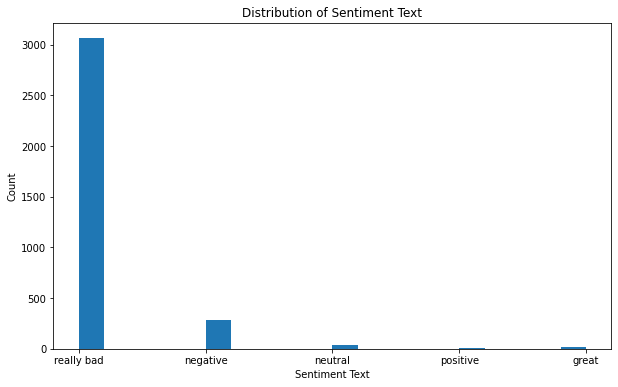

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_comment_combined['Sentiment_Text'], bins=20)
plt.title('Distribution of Sentiment Text')
plt.xlabel('Sentiment Text')
plt.ylabel('Count')
plt.show()


This model predicts that the majority of the comments can be considered as negative comments. There is a slight chance of this is to be true since the majority of comments are groupped in the 0-10 votes group. Before we trust this insight as face value, let's see how our model confidently predict each comment.

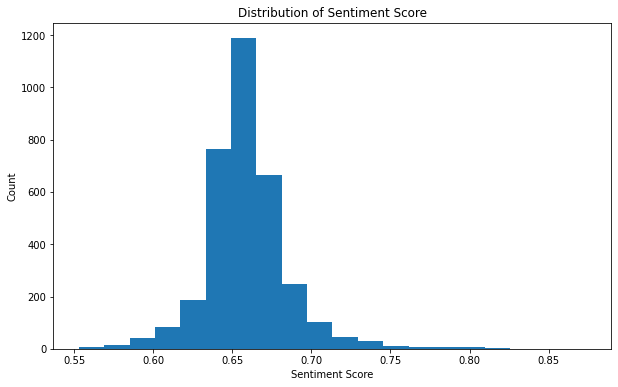

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(df_comment_combined['Sentiment_Score'], bins=20)
plt.title('Distribution of Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Count') 
plt.show()

If we take a look at the graphs above, we can see that this model is not that confident in predicting the sentiment class as the majority of prediction score is at around 60-70%. Although, this result is expected since we are using a pre-trained model built specifically from a product review dataset. It might be worthwhile to use a pre-trained model that is based on Twitter sentiment analysis and see if we can improve the performance going forward. Also, unfortunately, the author has not gotten his hand on any labeled YouTube sentiment data. If we can get our hands on said data, we can further improve this model by feeding our new dataset and trying to improve the accuracy.

In [18]:
# print top 10 comment with a class of 1 (really bad) and the most votes
df_comment_combined[(df_comment_combined['Sentiment_Class']==1) & (df_comment_combined['votes']>=10)].sort_values(by='votes', ascending=False).head(10)

,Comment,time,votes,reply,time_parsed,title,votes_group,Sentiment_Score,Sentiment_Class,Sentiment_Text
569,Which movie from the last 20 years is your fav?,2 years ago,311,False,1.607874e+09,top_20movies_of_the_century,above 100,0.650706,1,really bad
3143,The Thing deserves an honorable mention because it blends innovative practical effects and horror with themes of mistrust and paranoia.,2 months ago,197,False,1.665674e+09,top_20_scifi_movies,above 100,0.610916,1,really bad
232,In case anyone's wondering about the films in the intro: 0:00 8 1/2 0:10 There Will Be Blood 0:15 Salo 0:22 Duck Soup 0:29 Singin' in the Rain 0:34 Rashomon 0:40 Do the Right Thing 0:47 Chimes at Midnight 1:00 Ivan the Terrible,11 days ago,138,False,1.669995e+09,the_30_greatest_films,above 100,0.681089,1,really bad
2218,"Prisoners really threw me for a curveball, and it s ending was the most surprising. It was interesting to see Jackman in something other than the X-Men (at the time).",2 weeks ago,117,False,1.669739e+09,top_20_underated_movies,above 100,0.652196,1,really bad
2936,"I would've included Arrival (Denis Villeneuve), Interstellar (Christopher Nolan) and A Clockwork Orange (Stanley Kubrick)",2 months ago,101,False,1.665674e+09,top_20_scifi_movies,above 100,0.682519,1,really bad
3305,"I remember seeing 'Empire Strikes Back' at the cinema when it came out many moons ago, the classic line from Darth Vader had everyone yelling and screaming, it was such a surprise but also a great movie. You could have included 'The 5th Elements' and '12 Monkeys'- also great films. Cheers",2 months ago,70,False,1.665674e+09,top_20_scifi_movies,50-100,0.677758,1,really bad
545,The greatest film ever made is undeniably Black Panther,12 days ago,61,False,1.669908e+09,the_30_greatest_films,50-100,0.641293,1,really bad
1670,"Children of men. Didn t make a profit in theatres and not nearly enough recognition at awards season, though it being one of the best movies I ve seen of the last couple decades. Seriously this movie is beyond amazing and it frustrates me that no one talks about it",11 days ago,58,False,1.669998e+09,top_20_underated_movies,50-100,0.667044,1,really bad
422,THANK YOU. I hate when people try to be all mysterious to get me to watch the video. Show the list and I'll decide if the opinion is worth 2 plus hours of viewing. Don't try to be slick!,12 days ago,52,True,1.669908e+09,the_30_greatest_films,50-100,0.653152,1,really bad
2295,"The most underrated film that I've seen is Stranger Than Fiction starring Will Farrell. It's one of the best movies that I've watched, and it's a movie that I think everyone should see once in their lifetime.",2 weeks ago,52,False,1.669739e+09,top_20_underated_movies,50-100,0.626775,1,really bad


To further validate the performance analysis, let's take a look at the top 10 comments that are predicted as really bad (class = 1), but have a lot of votes. Just by looking at the texts, the author personally think that none of the texts are considered as negative. These are most likely netural comments with some hint of positivity because all of these comments are a list of movies that the commenters think are the best. Therefore, we can conclude that this pre-trained model is not suitable to predict YouTube comments' sentiment score.

Now that we have tested out one of the most advanced models available out there, let's try to build our own basic sentiment model and compare the result between the two. To do this, we are going to label our data using the NLTK module, specifically using the Vader lexicon. The way this module work is that they have a dictionary of words with a polarity score ranging from -1 to 1. If the polarity score of a given word is above and equal to 0.05, then we classify that word as positive. If the polarity score of a given word is below and equal to -0.05, then we classify that word as negative. The rest can be classified as neutral.

In [ ]:
!pip install nltk

In [19]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

df_comment_polarity = df_comment_combined.copy()

nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()
df_comment_polarity["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df_comment_polarity["Comment"]]
df_comment_polarity["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df_comment_polarity["Comment"]]
df_comment_polarity["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df_comment_polarity["Comment"]]
df_comment_polarity['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in df_comment_polarity["Comment"]]
score = df_comment_polarity["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df_comment_polarity["Sentiment"] = sentiment
df_comment_polarity.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Comment,time,votes,reply,time_parsed,title,votes_group,Sentiment_Score,Sentiment_Class,Sentiment_Text,Positive,Negative,Neutral,Compound,Sentiment
0,"Skip the waitlist and invest in blue-chip art for the very first time by signing up for Masterworks: https://masterworks.art/cinema Purchase shares in great masterpieces from artists like Pablo Picasso, Banksy, Andy Warhol, and more. See important Masterworks disclosures: http://masterworks.io/cd",12 days ago,15,False,1.669908e+09,the_30_greatest_films,10-20,0.665403,1,really bad,0.297,0.000,0.703,0.9243,Positive
1,"Not bad, this list, but I miss Songs From the Second Floor, Days of Heaven and A Man Escaped.",28 minutes ago,0,False,1.670944e+09,the_30_greatest_films,NaN,0.691868,1,really bad,0.286,0.085,0.629,0.6678,Positive
2,I see Akira and I I doubt,46 minutes ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.665843,1,really bad,0.000,0.455,0.545,-0.3612,Negative
3,Thank you!,1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.637606,1,really bad,0.736,0.000,0.264,0.4199,Positive
4,"YouTube lists of best films are usually difficult to read. Anglo-American lists are, for the most part insufferable privileging every manner of mediocre but culturally significant American film. But this list is different. Of course it's not the list I would make; lists are too subjective for th...",1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.680178,2,negative,0.227,0.015,0.759,0.9779,Positive


In [20]:
df_comment_polarity=df_comment_polarity.drop(['Positive','Negative','Neutral','Compound'],axis=1)
df_comment_polarity.head()

,Comment,time,votes,reply,time_parsed,title,votes_group,Sentiment_Score,Sentiment_Class,Sentiment_Text,Sentiment
0,"Skip the waitlist and invest in blue-chip art for the very first time by signing up for Masterworks: https://masterworks.art/cinema Purchase shares in great masterpieces from artists like Pablo Picasso, Banksy, Andy Warhol, and more. See important Masterworks disclosures: http://masterworks.io/cd",12 days ago,15,False,1.669908e+09,the_30_greatest_films,10-20,0.665403,1,really bad,Positive
1,"Not bad, this list, but I miss Songs From the Second Floor, Days of Heaven and A Man Escaped.",28 minutes ago,0,False,1.670944e+09,the_30_greatest_films,NaN,0.691868,1,really bad,Positive
2,I see Akira and I I doubt,46 minutes ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.665843,1,really bad,Negative
3,Thank you!,1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.637606,1,really bad,Positive
4,"YouTube lists of best films are usually difficult to read. Anglo-American lists are, for the most part insufferable privileging every manner of mediocre but culturally significant American film. But this list is different. Of course it's not the list I would make; lists are too subjective for th...",1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.680178,2,negative,Positive


We didn't do any pre-processing of our text when we were utilizing transformers' pre-trained model. However, we do need to pre-process our text data to build our own model to minimize potential errors. The pre-processer steps are as follow:
1. First, we lower all the texts
2. We remove punctuation from the texts
3. We remove multiple spaces from the texts ('  ')
4. We remove special characters from the texts
5. We remove stop words from the texts, and
6. We lemmatize our words to its base form

In [21]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer


stop_words = set(stopwords.words('english'))
lzr = WordNetLemmatizer()


def text_processing(text):   
    # convert text into lowercase
    text = text.lower()
    
    # remove punctuations from text
    text = re.sub('[%s]' % re.escape(punctuation), "", text)
    
    # remove references and hashtags from text
    text = re.sub("^a-zA-Z0-9$,.", "", text)
    
    # remove multiple spaces from text
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # remove special characters from text
    text = re.sub(r'\W', ' ', text)

    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    
    # lemmatizer using WordNetLemmatizer from nltk package
    text=' '.join([lzr.lemmatize(word) for word in word_tokenize(text)])

    return text

In [22]:
nltk.download('omw-1.4')
df_comment_polarity['Comment_preprocessed'] = df_comment_polarity['Comment'].apply(lambda text: text_processing(text))
df_comment_polarity.head()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Comment,time,votes,reply,time_parsed,title,votes_group,Sentiment_Score,Sentiment_Class,Sentiment_Text,Sentiment,Comment_preprocessed
0,"Skip the waitlist and invest in blue-chip art for the very first time by signing up for Masterworks: https://masterworks.art/cinema Purchase shares in great masterpieces from artists like Pablo Picasso, Banksy, Andy Warhol, and more. See important Masterworks disclosures: http://masterworks.io/cd",12 days ago,15,False,1.669908e+09,the_30_greatest_films,10-20,0.665403,1,really bad,Positive,skip waitlist invest bluechip art first time signing masterworks httpsmasterworksartcinema purchase share great masterpiece artist like pablo picasso banksy andy warhol see important masterworks disclosure httpmasterworksiocd
1,"Not bad, this list, but I miss Songs From the Second Floor, Days of Heaven and A Man Escaped.",28 minutes ago,0,False,1.670944e+09,the_30_greatest_films,NaN,0.691868,1,really bad,Positive,bad list miss song second floor day heaven man escaped
2,I see Akira and I I doubt,46 minutes ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.665843,1,really bad,Negative,see akira doubt
3,Thank you!,1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.637606,1,really bad,Positive,thank
4,"YouTube lists of best films are usually difficult to read. Anglo-American lists are, for the most part insufferable privileging every manner of mediocre but culturally significant American film. But this list is different. Of course it's not the list I would make; lists are too subjective for th...",1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.680178,2,negative,Positive,youtube list best film usually difficult read angloamerican list part insufferable privileging every manner mediocre culturally significant american film list different course list would make list subjective possible list three admirable quality selfreflective cinematically cosmopolitan historic...


Next, we need to encode our text data before fitting them into a model. This is because we can't pass raw text into machines as input. Therefore, we need to convert them to numbers via encoding. Text encoding is a process to convert meaningful text into a number or vector representation to preserve the context and relationship between words and sentences, such that a machine can understand the pattern associated with any text and can make out the context of sentences. In other words, we are labeling each comment in relation to the sentiment class.

In [ ]:
!pip install sklearn

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_comment_polarity['Sentiment'] = le.fit_transform(df_comment_polarity['Sentiment'])

In [24]:
processed_data = {
    'Sentence':df_comment_polarity['Comment_preprocessed'],
    'Sentiment':df_comment_polarity['Sentiment']
}

processed_data = pd.DataFrame(processed_data)

print(processed_data['Sentiment'].value_counts())
processed_data.head()

2    1721
1     898
0     791
Name: Sentiment, dtype: int64


,Sentence,Sentiment
0,skip waitlist invest bluechip art first time signing masterworks httpsmasterworksartcinema purchase share great masterpiece artist like pablo picasso banksy andy warhol see important masterworks disclosure httpmasterworksiocd,2
1,bad list miss song second floor day heaven man escaped,2
2,see akira doubt,0
3,thank,2
4,youtube list best film usually difficult read angloamerican list part insufferable privileging every manner mediocre culturally significant american film list different course list would make list subjective possible list three admirable quality selfreflective cinematically cosmopolitan historic...,2


We now have the code for every comment in relation to their sentiment class. The groupings are as follows:
1. Sentiment = 0 represents the neutral comments
2. Sentiment = 1 represents the negative comments
3. Sentiment = 2 represents the positive comments

It looks like we have an unbalanced dataset in our hands. Let's use resampling to balance the dataset before training the model. To do this, we will upsample both the negative and neutral data to match the number of positive data.

In [25]:
from sklearn.utils import resample

df_neutral = processed_data[(processed_data['Sentiment']==1)] 
df_negative = processed_data[(processed_data['Sentiment']==0)]
df_positive = processed_data[(processed_data['Sentiment']==2)]

# upsample minority classes
df_negative_upsampled = resample(df_negative, 
                                 replace=True,    
                                 n_samples= 1721, 
                                 random_state=42)  

df_neutral_upsampled = resample(df_neutral, 
                                 replace=True,    
                                 n_samples= 1721, 
                                 random_state=42)  


# Concatenate the upsampled dataframes with the neutral dataframe
final_data = pd.concat([df_negative_upsampled,df_neutral_upsampled,df_positive])

In [26]:
final_data['Sentiment'].value_counts()

0    1721
1    1721
2    1721
Name: Sentiment, dtype: int64

We are almost ready to train the model! To do this, we will use a CountVectorizer module from sklearn. CountVectorizer will convert our collection of text documents (comments) to a matrix of token counts. If you're interested in using other methods, you can check TF-IDF and Word2Vec among many others.

In [27]:
corpus = []
for sentence in final_data['Sentence']:
    corpus.append(sentence)
corpus[0:5]

['literally persona moron',
 'prophecy frailty thing denver youre dead identity',
 'something wrong watch mojo',
 '',
 'second overall mostly overwhelming sense confusion']

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(corpus).toarray()
y = final_data.iloc[:, -1].values

All set! Now let's train our model using our newly created corpus. First, we split the data into train dataset and test dataset. We will then fit the train dataset into our model. For this exercise, we will use Gaussian Naive Bayes as our classifier. 

For one, Naive Bayes classifiers have been heavily used for text classification and text analysis machine learning problems. As for the reason for using a Gaussian Naive Bayes instead of the other types of Naive Bayes is that we have a CountVectorizer object which contains real or continuous-valued datasets rather than categorical or discrete-valued features. To read more details on what and how Naive Bayes works, you can visit this [link](https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a).

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

Now let's see how our model peforme by predicting our test dataset.

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

nb_score = accuracy_score(y_test, y_pred)
print('accuracy',nb_score)

[[261  63  15]
 [ 10 328   1]
 [123  66 166]]
accuracy 0.7308809293320426


Although it is not amazingly accurate, the author thinks that this accuracy score is not too shabby for our first iteration of this model. Our model correctly predict the positive class 261 times and mistakenly classified positive comments to other classes 78 times. Our model has high accuracy in predicting neutral comments. However, it seems that our model has problems correctly classifying negative comments. It seems to classify some negative comments as positive. However, with more detailed fine-tuning, especially given a lot more data to work with, the author believes that we can improve the model performance further.

That concludes our analysis of YouTube comments sentiment score. That was fun. Now, let's explore our second objective, topic modeling. There are multiple ways to go about this problem, such as LSA and LDA. However, the author came across a new module that seems to be interesting. It utilizes the transformers architecture making this module one of the most advance modules to solve topic modeling problems available out there. This modeule is called BERTopic. You can check the original post and the creator of this module, [here](https://towardsdatascience.com/interactive-topic-modeling-with-bertopic-1ea55e7d73d8).

According to the original post, BERTopic is a topic modeling technique that leverages BERT embeddings and a class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. Our objective here is to see whether if we can find movies that the viewers love, regardless of what the video is telling us. Let's test this out!

In [ ]:
!pip install bertopic

In [31]:
from bertopic import BERTopic

# we are using multinglual bert model in case there are comments in other languages
model = BERTopic(language="multilingual", verbose=True)
topics, probabilities = model.fit_transform(df_comment_combined['Comment'])

Batches:   0%|          | 0/107 [00:00<?, ?it/s]

2022-12-13 17:55:28,655 - BERTopic - Transformed documents to Embeddings
2022-12-13 17:55:50,330 - BERTopic - Reduced dimensionality
2022-12-13 17:55:50,550 - BERTopic - Clustered reduced embeddings


In [32]:
df_comment_combined['topic'] = topics
df_comment_combined['topic_probability'] = probabilities
df_comment_combined.head()

,Comment,time,votes,reply,time_parsed,title,votes_group,Sentiment_Score,Sentiment_Class,Sentiment_Text,topic,topic_probability
0,"Skip the waitlist and invest in blue-chip art for the very first time by signing up for Masterworks: https://masterworks.art/cinema Purchase shares in great masterpieces from artists like Pablo Picasso, Banksy, Andy Warhol, and more. See important Masterworks disclosures: http://masterworks.io/cd",12 days ago,15,False,1.669908e+09,the_30_greatest_films,10-20,0.665403,1,really bad,1,0.950595
1,"Not bad, this list, but I miss Songs From the Second Floor, Days of Heaven and A Man Escaped.",28 minutes ago,0,False,1.670944e+09,the_30_greatest_films,NaN,0.691868,1,really bad,60,0.921849
2,I see Akira and I I doubt,46 minutes ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.665843,1,really bad,36,1.000000
3,Thank you!,1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.637606,1,really bad,51,1.000000
4,"YouTube lists of best films are usually difficult to read. Anglo-American lists are, for the most part insufferable privileging every manner of mediocre but culturally significant American film. But this list is different. Of course it's not the list I would make; lists are too subjective for th...",1 hour ago,0,False,1.670942e+09,the_30_greatest_films,NaN,0.680178,2,negative,1,1.000000


In [41]:
# we exclude the first row of topic (-1) since according the documentation it is the topic for the comments that do not belong to any topic
print(model.get_topic_info()[1:11])
print(model.get_topic_freq()[1:11])
print("Total number of topics =",len(model.get_topic_info()))

    Topic  Count                                  Name
1       0    148                  0_it_movie_film_seen
2       1    145                1_movies_films_list_of
3       2    111         2_slotterbeck_scott_he_conner
4       3     68                   3_top_list_your_100
5       4     61            4_knight_dark_the_wrestler
6       5     61      5_interesting_thing_37th_brugges
7       6     53                 6_fi_sci_movies_thing
8       7     52      7_tomorrow_edge_day_independence
9       8     51  8_interstellar_mention_list_district
10      9     51     9_underrated_most_pictures_movies
    Topic  Count
1       0    148
2       1    145
3       2    111
4       3     68
5       4     61
6       5     61
7       6     53
8       7     52
10      8     51
9       9     51
Total number of topics = 73


The column count above pertains to the number of comments belong to each topic. From looking at the top 10 most frequent topics, it seems that there some trend that we can infer from this model. Let's dissect them one by one.

In [46]:
print(model.get_topic(0))
df_comment_combined[df_comment_combined['topic']==0]['Comment'].head(10)

[('it', 0.02405560100514443), ('movie', 0.021685463917034298), ('film', 0.01823237795707298), ('seen', 0.014154609017566122), ('haven', 0.014004327842367303), ('in', 0.01391073454952514), ('that', 0.013373185839667049), ('was', 0.011850759586434832), ('to', 0.011742770245087646), ('great', 0.011218736787643529)]


20     Hey! I have to use this opportunity to mention the role your channel has played in my life. Your video about Colour in Storytelling has been one of my absolute favourite on this platform. I watched it back when it came out and I was in highschool. I've always had an interest in cinematography bu...
82     I think I m obliged by eldritch forces and a part of my own mind that (at 29) I m still too young to understand, to say that stalker is my favourite film. I still don t understand that film but, like a moth to a flame or like a human mind to a dmt spirit, I m drawn back again and again to its me...
92                                                                                                                                                                           I understand why many love it but I've rarely been as uninterested and bored as when I watched Ordet. I need to give it another shot.
93                                                                    Fanny and

Topic 0 is not exactly clear. However, several example of the comments belonging to topic 0 seem to tell that topic 0 consists of comments discussing the content of the video. The comments can be in a form of viewers who agrees with the content of the video, or debating the entries of the video.

In [47]:
print(model.get_topic(3))
df_comment_combined[df_comment_combined['topic']==3]['Comment'].head(10)

[('top', 0.05648371017753901), ('list', 0.05619686726786684), ('your', 0.03741259319928278), ('100', 0.030033692542842966), ('great', 0.027543089697893562), ('number', 0.02444549032958005), ('my', 0.02269937901930084), ('good', 0.02198528519510254), ('this', 0.02182319393649442), ('would', 0.020743214941080796)]


39                                                                                                                                                                                                                                                                Agree w your top pick.  Both GF1 &2 are perfect.
77                                                                                                                                                                                                                                                                    Thanks for this effort. Many are on my list.
78                                                                                                                                                                                                                                                           I can t stress how perfect this list is. Unreal job  
139    Unironically one of the wisest things I ve ever heard some say is that y

Topic 3 seems to consist of comments who agree with the ranking of the movies.

In [49]:
print(model.get_topic(6))
df_comment_combined[df_comment_combined['topic']==6]['Comment'].head(10)

[('fi', 0.06020789134220435), ('sci', 0.06000553928985316), ('movies', 0.017524868723085753), ('thing', 0.014431570341611645), ('top', 0.014378740335612284), ('time', 0.013354668614584495), ('the', 0.013267266164255727), ('is', 0.013263113877676855), ('horror', 0.012948718226028041), ('many', 0.01247648828299628)]
1642                                                                                                                                                                                                                          Upgrade is the best cyberpunk movie of a last decade, yet very few people mentions it
1837                                                                                                                                                                                                                                                                Children of men is the finest sci fi movie imo.
2410                                                                

Topic 7 seems to consist of comments from people that wants to share their favorite sci-fi movies.

BERTopic seems really good in grouping comments together to create topics. With that said, the model predicts 73 potential topics from our dataset. That seems to be way too big. Let's see if we can better specify the number of topics.

In [50]:
model.visualize_topics()

The module also allows us to create an interactive chart of the potential topics from our dataset. From looking at the graph, it looks like most topics are really close to one another. Let's try to group topics that are close into one group and tell BERTopic to reduce the maximum potential topics. There seem to be 7 big topics, but for now, let's ask BERTopic to decide the optimum number of topic for us.

In [51]:
model_auto = BERTopic(language="multilingual", verbose=True, nr_topics="auto")
topics_auto, probabilities_auto = model_auto.fit_transform(df_comment_combined['Comment'])

Batches:   0%|          | 0/107 [00:00<?, ?it/s]

2022-12-13 18:21:01,000 - BERTopic - Transformed documents to Embeddings
2022-12-13 18:21:16,342 - BERTopic - Reduced dimensionality
2022-12-13 18:21:16,530 - BERTopic - Clustered reduced embeddings
2022-12-13 18:21:17,754 - BERTopic - Reduced number of topics from 71 to 36


In [54]:
print(model_auto.get_topic_info().head(10))
print(model_auto.get_topic_freq().head(10))
print("Total number of topics =",len(model_auto.get_topic_info()))

   Topic  Count                              Name
0     -1   1014                  -1_the_of_and_is
1      0   1331                   0_the_of_it_and
2      1    177      1_video_send_direct_feedback
3      2     74      2_social_network_channel_the
4      3     62              3_knight_dark_the_is
5      4     51    4_interstellar_mention_list_on
6      5     47  5_tomorrow_day_edge_independence
7      6     41      6_no_bubblegum_whiplash_nope
8      7     39          7_blade_runner_2049_than
9      8     38      8_worst_hated_movie_terrible
    Topic  Count
0       0   1331
1      -1   1014
2       1    177
3       2     74
4       3     62
5       4     51
6       5     47
7       6     41
8       7     39
10      8     38
Total number of topics = 36


It seems the model still categorized way too many topics. We might need to further reduce our topics based on the topic chart above. Let's start by defining our topic to 10.

In [59]:
model_manual = BERTopic(language="multilingual", verbose=True, nr_topics=10)
topics_manual, probabilities_manual = model_manual.fit_transform(df_comment_combined['Comment'])

Batches:   0%|          | 0/107 [00:00<?, ?it/s]

2022-12-13 18:28:04,238 - BERTopic - Transformed documents to Embeddings
2022-12-13 18:28:19,424 - BERTopic - Reduced dimensionality
2022-12-13 18:28:19,641 - BERTopic - Clustered reduced embeddings
2022-12-13 18:28:21,399 - BERTopic - Reduced number of topics from 72 to 11


In [60]:
print(model_manual.get_topic_info())
print(model_manual.get_topic_freq())
print("Total number of topics =",len(model_manual.get_topic_info()))

    Topic  Count                                Name
0      -1   2257                    -1_the_of_and_is
1       0    218                  0_it_movie_the_and
2       1    165        1_dark_social_network_knight
3       2    159             2_video_for_send_direct
4       3    154                 3_the_of_lord_rings
5       4     98          4_slotterbeck_scott_you_he
6       5     81    5_moonlight_sunshine_the_eternal
7       6     72  6_interstellar_district_mention_is
8       7     70         7_no_lol_whiplash_bubblegum
9       8     69               8_list_top_your_great
10      9     67            9_underrated_the_most_is
    Topic  Count
0      -1   2257
1       0    218
2       1    165
3       2    159
4       3    154
5       4     98
6       5     81
7       6     72
8       7     70
9       8     69
10      9     67
Total number of topics = 11


In [61]:
model_manual.visualize_topics()

And there you go! It seems we can look for some recommendations if we explore topics 1, 3, 4, 5, 6, and 7. Overall, BERTopic is a wonderful module that can help you solve topic modeling problems. It also works in multiple languages. There are other parameters that we can optimize further to improve our grouping capability. However, in the interest of time, and not wanting to prolong this analysis even further, we will stop here for now. It would be great to analyze a different combination of pre-trained transformer models for both sentiment analysis and topic modeling. It would also be interesting if we can create an automated movie recommendation that utilizes this data point as one of its features. 